In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import model_selection
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from textblob import TextBlob
from collections import Counter
from imblearn.over_sampling import SMOTE
import nltk.data

In [2]:
# read the dataset
reviews_data = pd.read_json(r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json", lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]


# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [3]:
""""
Split each review into sentences
and preprocess each sentence
"""
sentenceEnders = re.compile('[.!?]')

stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords.extend(['wear', 'shoe', 'size', 'fit', 'look', 'one', 'good'])

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']: 
    if ((index % 10000) == 0):
        print(str(round(((index/len(reviews_data)*100)), 2)) + "% of the total reviews have been preprocessed")
    review_sentences = sentenceEnders.split(review)
    for sentence in review_sentences:
        raw_sentence = sentence
        sentence = re.sub(r'not a *', 'not',sentence)
        sentence = re.sub(r'not *', 'not',sentence) 
        sentence = re.sub(r"\w+n't ", 'not',sentence) 
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence = [word for word in sentence if not word in stopwords]
        sentence = ' '.join(sentence)
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            review["raw_sentence"] = raw_sentence
            preprocessed_data.append(review)
    index+=1

0.0% of the total reviews have been preprocessed
3.59% of the total reviews have been preprocessed
7.18% of the total reviews have been preprocessed
10.77% of the total reviews have been preprocessed
14.35% of the total reviews have been preprocessed
17.94% of the total reviews have been preprocessed
21.53% of the total reviews have been preprocessed
25.12% of the total reviews have been preprocessed
28.71% of the total reviews have been preprocessed
32.3% of the total reviews have been preprocessed
35.88% of the total reviews have been preprocessed
39.47% of the total reviews have been preprocessed
43.06% of the total reviews have been preprocessed
46.65% of the total reviews have been preprocessed
50.24% of the total reviews have been preprocessed
53.83% of the total reviews have been preprocessed
57.41% of the total reviews have been preprocessed
61.0% of the total reviews have been preprocessed
64.59% of the total reviews have been preprocessed
68.18% of the total reviews have been

In [4]:
print("Before preprocessing: ", reviews_data['reviewText'][28620])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 28620])
print(len(preprocessed_data))

Before preprocessing:  BUCKLE DESIGNI have a variety of these, bought over a span of at least 20 years, and almost certainly made by several different companies. Although the Rothco buckles are "made in Taiwan", they are identical (down to the smallest detail) to solid-brass buckles "made in America" which I purchased 15 years ago.  Apparently, all buckles of this general type are made to the same government specified design.  These are uniform belts NOT utility belts.  If you want utility belts to hang gear from, consider5.11 TDU 1.5-Inch BeltorUTG Heavy Duty Web Belt - BlackPros/Cons:  I happen to like the precise adjustment, and the ability to wear a belt very loosely when I don't actually need it to hold up my pants---such as when working at my desk. I like being able to adjust the belt on the "inside" (where the extra belt material is not visible), so that the end of the belt sticks out only 1" or so on the outside when worn loosely, and extends to my first belt loop when worn tig

In [5]:
# Split Dataset into training and test
indexes = [i for i in range(len(reviews_data))]

Train_X_index, Test_X_index, Train_Y_review, Test_Y_review = model_selection.train_test_split(indexes,ratings,test_size=0.3, random_state=42)

df = pd.DataFrame(preprocessed_data)

train = df[df['index'].isin(Train_X_index)]
Train_Y = train['rating'].tolist()
Train_X_raw = train['raw_sentence'].tolist() 
Train_X = train['sentence'].tolist()
Train_index = train['index'].tolist()


test = df[df['index'].isin(Test_X_index)]
Test_Y = test['rating'].tolist()
Test_X = test['sentence'].tolist()
Test_X_raw = test['raw_sentence'].tolist()
Test_index = test['index'].tolist()

all_sentences = Train_X + Test_X

In [6]:
def calculate_textblob_score(sentence):
    return TextBlob(sentence).sentiment.polarity

def get_sentiment_from_score(predicted_score):
    if predicted_score > 0:
        return 1
    elif predicted_score < 0:
        return -1
    else:
        return 0

In [7]:
data = {'raw_sentence': Train_X_raw, 'sentence': Train_X}
dataframe_lexicon = pd.DataFrame(data)

# Calculate predicted scores using afinn lexicon approcach
dataframe_lexicon['predicted_score'] = dataframe_lexicon.apply(lambda x: calculate_textblob_score(x['raw_sentence']), axis=1)

# Get the sentiment from the caluclated score
dataframe_lexicon['predicted_sentiment'] = dataframe_lexicon.apply(lambda x: get_sentiment_from_score(x['predicted_score']), axis=1)

Train_Y = list(dataframe_lexicon['predicted_sentiment'])

In [8]:
# Word Vectorization
Hashing_vect = HashingVectorizer(alternate_sign=False)
Hashing_vect.fit(all_sentences)
Train_X_Hashing = Hashing_vect.transform(Train_X)
Test_X_Hashing = Hashing_vect.transform(Test_X)

In [9]:
# Oversampling 
oversample = SMOTE(random_state=100)
X_SMOTE, y_SMOTE = oversample.fit_resample(Train_X_Hashing, Train_Y)

In [10]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element

-14
Accuracy:  63.48127766479244
-----------------------
              precision    recall  f1-score   support

    Negative       0.28      0.25      0.27      7996
     Neutral       0.13      0.30      0.19      9177
    Positive       0.86      0.73      0.79     66417

    accuracy                           0.63     83590
   macro avg       0.43      0.43      0.41     83590
weighted avg       0.73      0.63      0.67     83590



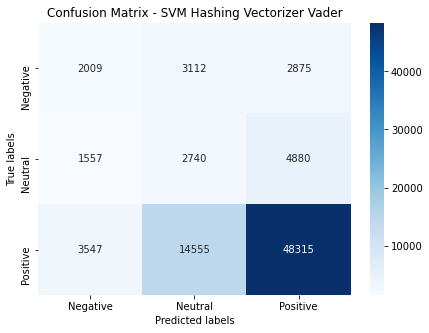

In [11]:
# Support Vector Machine with linear cernel

from sklearn.svm import LinearSVC

# Train the classifier
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_SMOTE,y_SMOTE)

predictions_SVM = clf.predict(Test_X_Hashing)

# Get grades by review
predicted_scores_frame = pd.DataFrame(np.column_stack([Test_index, predictions_SVM, Test_Y]), 
                               columns=['review Index', 'prediction', 'actual'])

print(len(predicted_scores_frame['review Index'].unique()) - len(Test_Y_review))

# for each review get all scores by review
scores_by_review_frame = predicted_scores_frame.groupby('review Index')['prediction'].apply(list)

majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = predicted_scores_frame.groupby('review Index')['actual'].first()
actual_scores = list(actual_scores_frame)

# get all indexes
review_indexes = predicted_scores_frame['review Index'].unique()

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)
print("-----------------------")

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM Hashing Vectorizer Vader'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/SVM_HashingVectorizer_Textblob.csv', index= True)

In [12]:
# write indexes of false classified reviews to a txt file

data = {"review_index": review_indexes, "predict": predicted_scores, "actual": actual_scores}

review_dataframe = pd.DataFrame(data)

# Save all falsed classified indexes
false_classified_indexes = review_dataframe['review_index'][review_dataframe['predict'] != review_dataframe['actual']]
false_classified_indexes = list(false_classified_indexes)
with open("indexes/SVM_HashingVectorizer_Textblob.txt", 'w') as f:
    for item in false_classified_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are neutral
negativePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 0)]
negativePredicted_neutralActual_indexes = list(negativePredicted_neutralActual_indexes)
with open("indexes/SVM_HashingVectorizer_Textblob_NegativePredicted_NeutralActual.txt", 'w') as f:
    for item in negativePredicted_neutralActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are positive
negativePredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 1)]
negativePredicted_positiveActual_indexes = list(negativePredicted_positiveActual_indexes)
with open("indexes/SVM_HashingVectorizer_Textblob_NegativePredicted_PositiveActual.txt", 'w') as f:
    for item in negativePredicted_positiveActual_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as neutral but they are negative
neutralPredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==0) & (review_dataframe['actual'] == -1)]
neutralPredicted_negativeActual_indexes = list(neutralPredicted_negativeActual_indexes)
with open("indexes/SVM_HashingVectorizer_Textblob_NeutralPredicted_NegativeActual.txt", 'w') as f:
    for item in neutralPredicted_negativeActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as neutral but they are positive
neutralPredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==0) & (review_dataframe['actual'] == 1)]
neutralPredicted_positiveActual_indexes = list(neutralPredicted_positiveActual_indexes)
with open("indexes/SVM_HashingVectorizer_Textblob_NeutralPredicted_PositiveActual.txt", 'w') as f:
    for item in neutralPredicted_positiveActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as positive but they are negative        
positivePredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==1) & (review_dataframe['actual'] == -1)]
positivePredicted_negativeActual_indexes = list(positivePredicted_negativeActual_indexes)
with open("indexes/SVM_HashingVectorizer_Textblob_PositivePredicted_NegativeActual.txt", 'w') as f:
    for item in positivePredicted_negativeActual_indexes:
        f.write("%s\n" % item)
 
# save those indexes who are predicted as positive but they are neutral 
positivePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==1) & (review_dataframe['actual'] == 0)]
positivePredicted_neutralActual_indexes = list(positivePredicted_neutralActual_indexes)
with open("indexes/SVM_HashingVectorizer_Textblob_PositivePredicted_NeutralActual.txt", 'w') as f:
    for item in positivePredicted_neutralActual_indexes:
        f.write("%s\n" % item)